In [1]:
!pip install tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import re
# !pip install nltk
import nltk
# !pip install spacy
import spacy
# !python -m spacy download en_core_web_lg
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
val_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [3]:
val_data.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [4]:
df.head(5)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df.columns = ['ID', 'Refers_to', 'Sentiment', 'Text']
val_data.columns = ['ID', 'Refers_to', 'Sentiment', 'Text']

In [6]:
df.isnull().sum()

ID             0
Refers_to      0
Sentiment      0
Text         686
dtype: int64

In [7]:
df.describe(include='all')

,ID,Refers_to,Sentiment,Text
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,Microsoft,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Refers_to  74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.dropna(axis=0, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         71655 non-null  int64 
 1   Refers_to  71655 non-null  object
 2   Sentiment  71655 non-null  object
 3   Text       71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [12]:
val_data

,ID,Refers_to,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [13]:
target = df['Sentiment']

In [14]:
texts = df["Text"]

In [15]:
texts.head()

0    I am coming to the borders and I will kill you...
1    im getting on borderlands and i will kill you ...
2    im coming on borderlands and i will murder you...
3    im getting on borderlands 2 and i will murder ...
4    im getting into borderlands and i can murder y...
Name: Text, dtype: object

In [16]:
text_lengths = [len(t.split()) for t in texts.values]

In [17]:
mean_length = np.mean(text_lengths)
print(f"Mean length of texts is {mean_length:.1f}")

Mean length of texts is 19.5


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


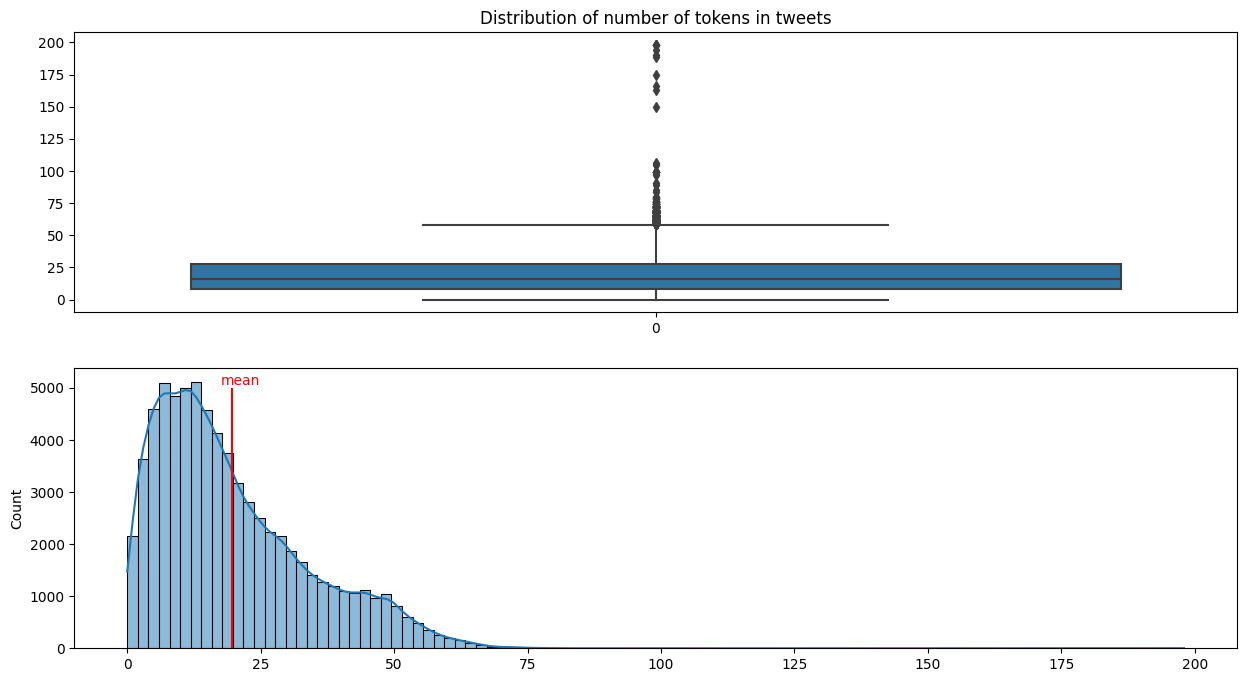

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lengths, ax=axes[0])
sns.histplot(text_lengths, bins=100, kde=True, ax=axes[1])
axes[1].vlines(mean_length, 0, 5000, color = 'r')
plt.annotate("mean", xy=(mean_length, 5000), xytext=(mean_length-2, 5050),
            color='r')
plt.show()

In [19]:
outliers = df['Text'][np.array(text_lengths) > 125]

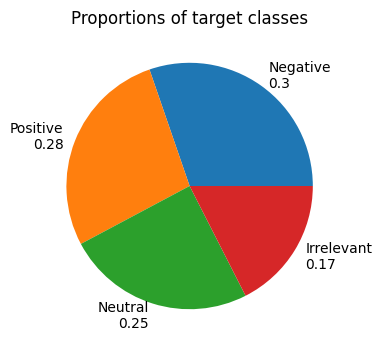

In [20]:
target_balance = df['Sentiment'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index])
plt.title('Proportions of target classes')
plt.show()

In [21]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(df['Text'], df['Sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


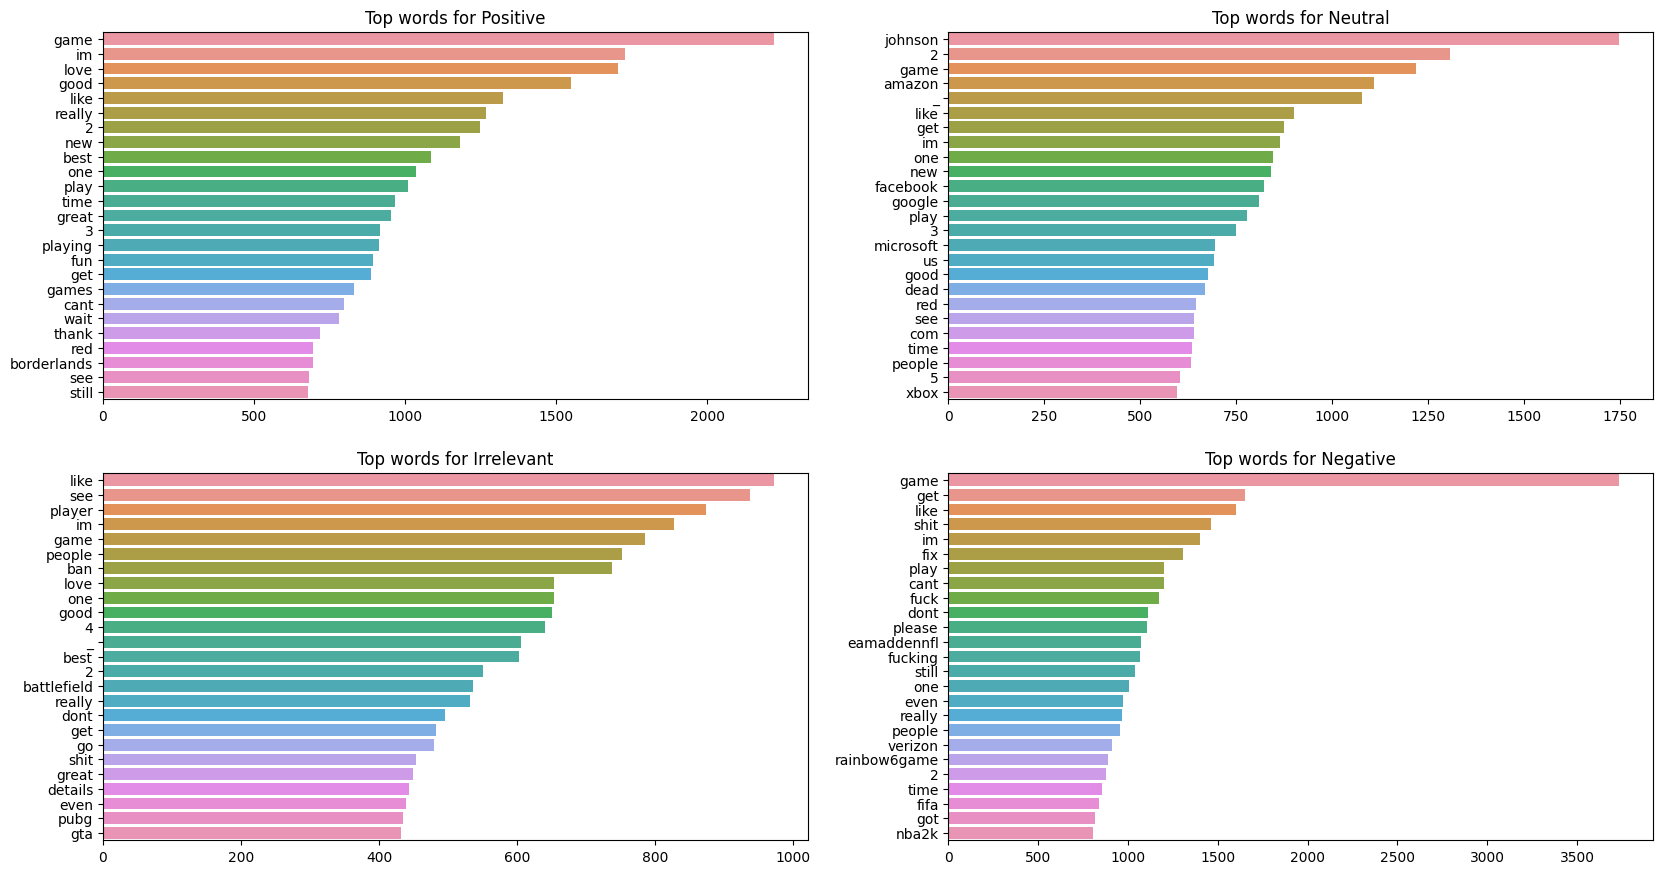

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

In [23]:
!pip install emoji
import emoji
import regex as re

def split_count(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(emoji.is_emoji(char) for char in word):
            emoji_list.append(word)
    
    return emoji_list

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [24]:
target_emojis = {
    'Positive': [],
    'Neutral': [],
    'Irrelevant': [],
    'Negative': []
}

pattern = re.compile('\u200d')
for i, text in enumerate(texts):
    emoji_count = split_count(text)
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[df['Sentiment'].iloc[i]].extend(emoji_count)

Top emojis for Positive 
 ['🤣', '🥰', '🥺', '🤔', '🤦', '🤩', '™', '🥳', '🤯', '🤷', '🦁', '🥴', '🤖', '🤤', '‼', '🥵', '🦊', '🤞', '🤸', '🤪']


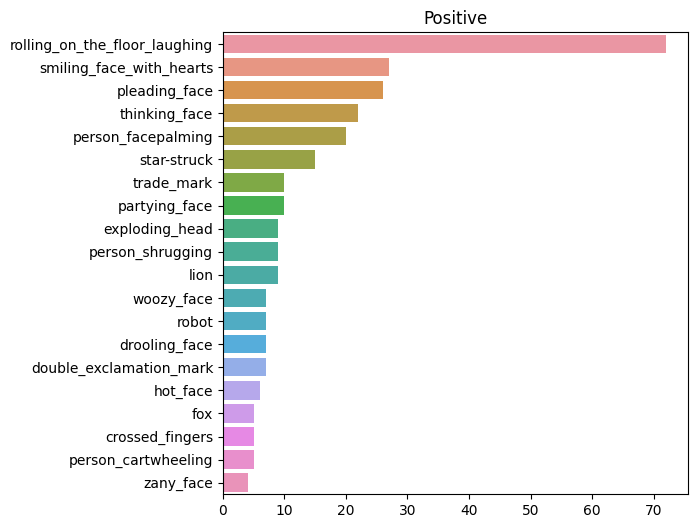

Top emojis for Neutral 
 ['🤣', '🤦', '🤔', '™', '🥺', '©', '🤷', '‼', '🥰', '🤯', '🤩', '🤠', '🥳', '🤨', '🤬', '🤡', '🧨', '🥴', '🧐', '🥇']


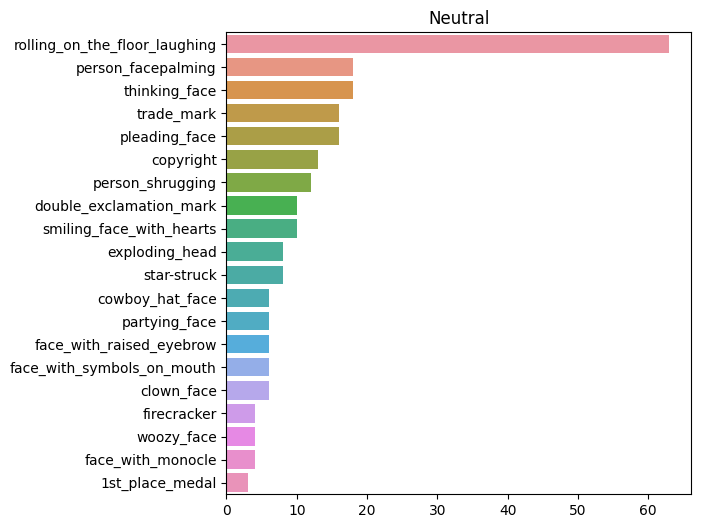

Top emojis for Irrelevant 
 ['🤣', '🥺', '🥰', '🤦', '🤔', '🤷', '🥳', '🤗', '🥴', '🤪', '🤓', '‼', '🤢', '🧘', '🦋', '🤬', '🤡', '🤧', '🤩', '🥄']


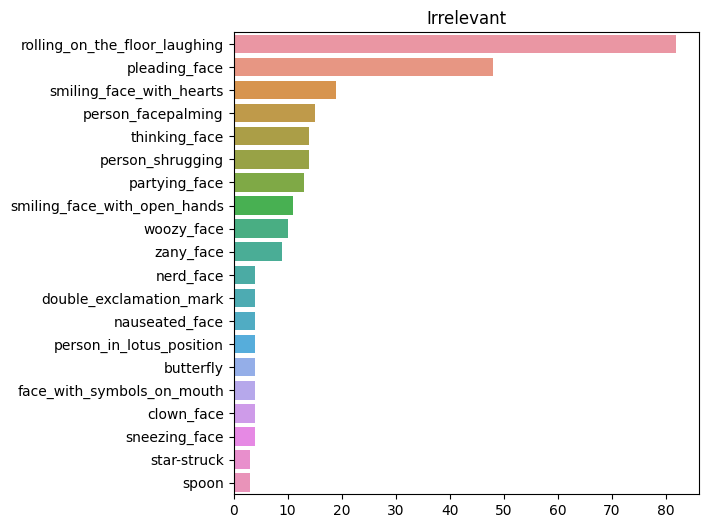

Top emojis for Negative 
 ['🤦', '🤣', '🥺', '🤬', '🥴', '🤷', '🤔', '🧢', '🤡', '🤢', '‼', '🤑', '™', '🤩', '🤓', '©', '🥰', '🤪', '🤨', '🤟']


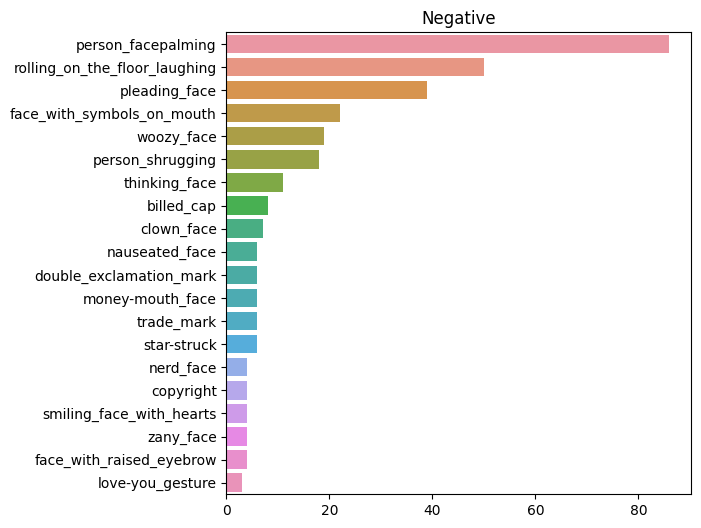

In [25]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(6,6))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print('=========='*10,  f'\nTop emojis for {t} \n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
        
    plt.title(f'{t}')
    plt.show()

In [26]:
!pip install spacy
!python -m spacy download en_core_web_lg

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_lg")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import emoji
import spacy
from nltk.corpus import stopwords
from tqdm import tqdm

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Initialize stopwords list
stopwords = set(stopwords.words('english'))

class Preprocessor:
    def __init__(self, stopwords=stopwords, max_len=200):
        self.stopwords = stopwords
        self.max_len = max_len
        self.tokenizer = Tokenizer()  # Initialize the tokenizer

    def remove_urls(self, texts):
        pattern = re.compile(r'(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]

    def remove_double_space(self, texts):
        pattern = re.compile(r' +')
        return [re.sub(pattern, ' ', text) for text in texts]

    def remove_punctuation(self, texts):
        pattern = re.compile(r'[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]

    def remove_stopwords(self, texts):
        return [' '.join([w for w in text.split() if w not in self.stopwords]) for text in tqdm(texts)]

    def remove_numbers(self, texts):
        return [' '.join([w for w in text.split() if not w.isdigit()]) for text in tqdm(texts)]

    def decode_emojis(self, texts):
        return [emoji.demojize(text, language='en') for text in texts]

    def lemmatize(self, texts):
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
        return lemmatized_texts

    def fit_tokenizer(self, texts):
        """Fit the tokenizer on the text data."""
        self.tokenizer.fit_on_texts(texts)
    
    def tokenize_texts(self, texts):
        """Tokenize texts and return padded sequences."""
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, padding='post', maxlen=self.max_len)
        return padded_sequences

In [28]:
texts[5]

"So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg"

In [29]:
# Step 1: Initialize the Preprocessor
preprocessor = Preprocessor()

# Step 2: Data Preprocessing
df['Processed_Text'] = preprocessor.remove_urls(df['Text'])
df['Processed_Text'] = preprocessor.remove_punctuation(df['Processed_Text'])
# df['Processed_Text'] = preprocessor.remove_stopwords(df['Processed_Text'])
df['Processed_Text'] = preprocessor.remove_numbers(df['Processed_Text'])
df['Processed_Text'] = preprocessor.decode_emojis(df['Processed_Text'])
df['Processed_Text'] = preprocessor.remove_double_space(df['Processed_Text'])
df['Processed_Text'] = preprocessor.lemmatize(df['Processed_Text'])

100%|██████████| 71655/71655 [07:04<00:00, 168.85it/s]


In [30]:
# Step 3: Fit the Tokenizer (After text preprocessing)
preprocessor.fit_tokenizer(df['Processed_Text'])

# Step 4: Tokenize Texts and Pad Sequences
X_padded = preprocessor.tokenize_texts(df['Processed_Text'])
X_padded = pad_sequences(X_padded, padding='post', maxlen=200)

# Step 5: Train-Test Split
from sklearn.model_selection import train_test_split
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df[['Sentiment']])  # Assuming the Sentiment column is already present in df

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [31]:
val_data['Processed_Text'] = preprocessor.remove_urls(val_data['Text'])
val_data['Processed_Text'] = preprocessor.remove_punctuation(val_data['Processed_Text'])
val_data['Processed_Text'] = preprocessor.remove_stopwords(val_data['Processed_Text'])
val_data['Processed_Text'] = preprocessor.remove_numbers(val_data['Processed_Text'])
val_data['Processed_Text'] = preprocessor.decode_emojis(val_data['Processed_Text'])
val_data['Processed_Text'] = preprocessor.remove_double_space(val_data['Processed_Text'])
val_data['Processed_Text'] = preprocessor.lemmatize(val_data['Processed_Text'])

val_X_sequences = preprocessor.tokenizer.texts_to_sequences(val_data['Processed_Text'])
val_X_padded = pad_sequences(val_X_sequences, padding='post', maxlen=200)

val_y = encoder.transform(val_data[['Sentiment']])

100%|██████████| 999/999 [00:05<00:00, 180.85it/s]


In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(57324, 200)
(14331, 200)
(57324, 4)
(14331, 4)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout, BatchNormalization

# Define vocabulary size, embedding dimension, and input length
vocab_size = len(preprocessor.tokenizer.word_index) + 1  # Include padding token
embedding_dim = 100  # Embedding dimensions
input_length = X_padded.shape[1]  # Length of input sequences

# Build the model
model013 = Sequential()

# Embedding layer
model013.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=input_length))

# LSTM layer
model013.add(Bidirectional(LSTM(units=128, dropout=0.3, return_sequences=True)))
model013.add(Bidirectional(LSTM(units=64)))

model013.add(Dense(128))
# model013.add(BatchNormalization())
model013.add(Dropout(0.3))
model013.add(Dense(64, activation='relu'))
model013.add(Dropout(0.3))

# Output layer
model013.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model013.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model013.build(input_shape=(None, X_padded.shape[1]))


# Print summary
model013.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,371,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,676 (10.66 MB)

 Trainable params: 2,795,676 (10.66 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model013.build(input_shape=(None, X_padded.shape[1]))

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [36]:
print(val_X_padded.shape)  # Should match X_train.shape
print(val_y.shape)  # Should match y_train.shape
print(X_train.shape)
print(y_train.shape)

(999, 200)
(999, 4)
(57324, 200)
(57324, 4)


In [40]:
history013 = model013.fit(X_train, y_train, epochs=5, validation_data=(val_X_padded, val_y))


Epoch 1/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 811s 450ms/step - accuracy: 0.4988 - loss: 1.1312 - val_accuracy: 0.8358 - val_loss: 0.4599
Epoch 2/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 792s 442ms/step - accuracy: 0.8003 - loss: 0.5356 - val_accuracy: 0.8819 - val_loss: 0.3267
Epoch 3/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 791s 441ms/step - accuracy: 0.8660 - loss: 0.3601 - val_accuracy: 0.8819 - val_loss: 0.3694
Epoch 4/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 790s 441ms/step - accuracy: 0.8935 - loss: 0.2776 - val_accuracy: 0.8909 - val_loss: 0.3841
Epoch 5/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 789s 440ms/step - accuracy: 0.9085 - loss: 0.2320 - val_accuracy: 0.8989 - val_loss: 0.3683


In [42]:
y_pred = model013.predict(X_test)

448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step


In [43]:
print(y_pred.shape)
print(y_test.shape)

(14331, 4)
(14331, 4)


In [47]:
y_pred[45]

array([0.02537756, 0.28076226, 0.44938746, 0.24447268], dtype=float32)

In [48]:
y_pred_classes = y_pred.argmax(axis=1)

In [52]:
y_test_classes = np.argmax(y_test, axis=1)

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Neutral', 'Positive', 'Negative', 'Irrelevant']))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.87      0.81      0.84      2455
    Positive       0.88      0.87      0.87      4433
    Negative       0.88      0.83      0.85      3532
  Irrelevant       0.80      0.89      0.84      3911

    accuracy                           0.85     14331
   macro avg       0.86      0.85      0.85     14331
weighted avg       0.85      0.85      0.85     14331

Confusion Matrix:
[[1979  136  111  229]
 [  82 3839  164  348]
 [ 108  212 2928  284]
 [ 109  192  135 3475]]


In [82]:
model013.save('sentiment_analysis_lstm_model.h5')

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional, BatchNormalization

# Define the model
model_gru1 = Sequential()

# Embedding layer
model_gru1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))

# Bidirectional GRU layers
model_gru1.add(Bidirectional(GRU(units=256, return_sequences=True)))  # First GRU layer
model_gru1.add(Bidirectional(GRU(units=128, return_sequences=False)))  # Second GRU layer

# Dropout and Dense layers
model_gru1.add(Dropout(0.3))
model_gru1.add(Dense(128))
model_gru1.add(BatchNormalization())
model_gru1.add(Dropout(0.3))

model_gru1.add(Dense(64))
model_gru1.add(BatchNormalization())
model_gru1.add(Dropout(0.3))

# Output layer for classification
model_gru1.add(Dense(4, activation='softmax'))  # Assuming 4 sentiment classes

# Compile the model
model_gru1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_gru1 = model_gru1.fit(X_train, y_train, epochs=5, validation_data=(val_X_padded, val_y))


Epoch 1/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.4730 - loss: 1.2690 - val_accuracy: 0.8208 - val_loss: 0.4975
Epoch 2/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.8036 - loss: 0.5449 - val_accuracy: 0.8969 - val_loss: 0.2907
Epoch 3/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.8726 - loss: 0.3526 - val_accuracy: 0.8799 - val_loss: 0.3383
Epoch 4/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9000 - loss: 0.2808 - val_accuracy: 0.8999 - val_loss: 0.3144
Epoch 5/5
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.9110 - loss: 0.2449 - val_accuracy: 0.8939 - val_loss: 0.3403


In [74]:
y_pred_gru = model_gru1.predict(X_test)

448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


In [79]:
y_pred_gru_classes = y_pred_gru.argmax(axis=1)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_gru_classes, target_names=['Neutral', 'Positive', 'Negative', 'Irrelevant']))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_gru_classes))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.86      0.78      0.82      2455
    Positive       0.88      0.84      0.86      4433
    Negative       0.84      0.84      0.84      3532
  Irrelevant       0.78      0.87      0.83      3911

    accuracy                           0.84     14331
   macro avg       0.84      0.83      0.84     14331
weighted avg       0.84      0.84      0.84     14331

Confusion Matrix:
[[1917  113  162  263]
 [ 127 3711  192  403]
 [  82  202 2963  285]
 [ 112  182  196 3421]]
